In [1]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
# import plotly.express
# import plotly.express as px
import pandas as pd
import cvxpy as cp
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import algorithms


In [2]:
num_iterations = 100

file_name = "geometric_small_p"

mean_size = 2
var_size = .1

algo_list = ['fixed_threshold', 'hope_guardrail_14', 'hope_guardrail_12', 'hope_guardrail_13', 'og_hope_guardrail_12', 'og_hope_guardrail_13']

In [3]:
def perish_dist(b, n):
    val = np.random.geometric(p = n**(-5/3))
    return val

In [4]:
def demand_dist(n, mean_size, var_size=.1):
    size = np.maximum(0, np.random.normal(loc=mean_size, scale=np.sqrt(var_size), size=n).astype(int))
    return size

In [5]:

num_groups = np.logspace(2, 12, base=1.5, num=25).astype(int)

data = []

for n in tqdm(num_groups):
    n = int(n) + 5
    max_budget = mean_size*n
    print(f'Num Locations: {n}, Max Budget: {max_budget}')
    offset_prob = helper.check_offset_expiry(perish_dist, lambda n: demand_dist(n, mean_size, var_size), n, max_budget)
    print(f' Probability process is offset expiring: {100*offset_prob}')

    # CALCULATES
    n_upper = helper.n_upper(lambda n: demand_dist(n, mean_size, var_size), n)
    
    num_valid = 0    

    x_lower_perish = helper.x_lower_line_search(perish_dist, lambda n: demand_dist(n, mean_size, var_size), n, max_budget, n_upper)
    x_lower_no_perish = (max_budget / n_upper[0])

    dperish = (max_budget / n_upper[0]) - x_lower_perish
    
    print(f'Necessary X_lower due to perishing: {x_lower_perish} and dperish: {dperish}')


    while num_valid < num_iterations:
        demands = demand_dist(n, mean_size, var_size)
        resource_perish = np.asarray([perish_dist(b,n) for b in range(max_budget)])

        check_optimality = [(max_budget / np.sum(demands))*np.sum(demands[:(t+1)])
                                - np.count_nonzero([resource_perish <= t]) for t in range(n)]
        if np.min(check_optimality) < 0: # checks if B/N is feasible in hindsight
            continue
        else:
            num_valid += 1
            
        xopt = max_budget / np.sum(demands)

        # print(f"Minimum L_T to get non trivial bound: {xopt - x_lower_perish} versus: {mean_size * (n**(-1/3))}")
        # Should also check feasibility of x_lower on this sample path that was sampled?
        
        for algo in algo_list:
            # print(algo)
            if algo == 'fixed_threshold':
                perish_un_allocate, waste, counterfactual_envy, hindsight_envy = algorithms.fixed_threshold(demands, resource_perish, max_budget, xopt, x_lower_perish, n)
            elif algo == 'hope_guardrail_12':
                perish_un_allocate, waste, counterfactual_envy, hindsight_envy = algorithms.hope_guardrail_perish(demands, resource_perish, max_budget, xopt, x_lower_perish, n, mean_size*(n**(-1/2)), lambda n: demand_dist(n, mean_size, var_size), perish_dist, n_upper)
            elif algo == 'hope_guardrail_13':
                perish_un_allocate, waste, counterfactual_envy, hindsight_envy = algorithms.hope_guardrail_perish(demands, resource_perish, max_budget, xopt, x_lower_perish, n, mean_size*(n**(-1/3)), lambda n: demand_dist(n, mean_size, var_size), perish_dist, n_upper)
            elif algo == 'hope_guardrail_14':
                perish_un_allocate, waste, counterfactual_envy, hindsight_envy = algorithms.hope_guardrail_perish(demands, resource_perish, max_budget, xopt, x_lower_perish, n, mean_size*(n**(-1/4)), lambda n: demand_dist(n, mean_size, var_size), perish_dist, n_upper)
            elif algo == 'og_hope_guardrail_12':
                perish_un_allocate, waste, counterfactual_envy, hindsight_envy = algorithms.hope_guardrail_original(demands, resource_perish, max_budget, xopt, x_lower_no_perish, n, mean_size*(n**(-1/2)), lambda n: demand_dist(n, mean_size, var_size), perish_dist, n_upper)
            elif algo == 'og_hope_guardrail_13':
                perish_un_allocate, waste, counterfactual_envy, hindsight_envy = algorithms.hope_guardrail_original(demands, resource_perish, max_budget, xopt, x_lower_no_perish, n, mean_size*(n**(-1/3)), lambda n: demand_dist(n, mean_size, var_size), perish_dist, n_upper)

            data_dict = {'NumGroups': n, 'Algorithm': algo, 'Norm': 'Hindsight_Envy', 'Value': hindsight_envy}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm': algo, 'Norm': 'Counterfactual_Envy', 'Value': counterfactual_envy}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm': algo, 'Norm': 'Waste', 'Value': waste}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm': algo, 'Norm': 'Perished_Un_Allocated', 'Value': perish_un_allocate}
            data.append(data_dict)

  0%|          | 0/25 [00:00<?, ?it/s]

Num Locations: 7, Max Budget: 14
 Probability process is offset expiring: 99.5
Starting value: 0.942190201597245
Final value: 0.7821902015972448
Necessary X_lower due to perishing: 0.7821902015972448 and dperish: 0.16000000000000014
Num Locations: 7, Max Budget: 14
 Probability process is offset expiring: 99.4
Starting value: 0.9481459916619341
Final value: 0.808145991661934
Necessary X_lower due to perishing: 0.808145991661934 and dperish: 0.14000000000000012
Num Locations: 8, Max Budget: 16
 Probability process is offset expiring: 100.0
Starting value: 0.9586410002770557
Final value: 0.8186410002770556
Necessary X_lower due to perishing: 0.8186410002770556 and dperish: 0.14000000000000012
Num Locations: 8, Max Budget: 16
 Probability process is offset expiring: 99.9
Starting value: 0.9566130258825312
Final value: 0.806613025882531
Necessary X_lower due to perishing: 0.806613025882531 and dperish: 0.15000000000000013
Num Locations: 9, Max Budget: 18
 Probability process is offset expi

In [6]:
df = pd.DataFrame.from_records(data)
df.to_csv('./data/' + file_name + '.csv', index=False)
df = pd.read_csv('./data/' + file_name + '.csv')

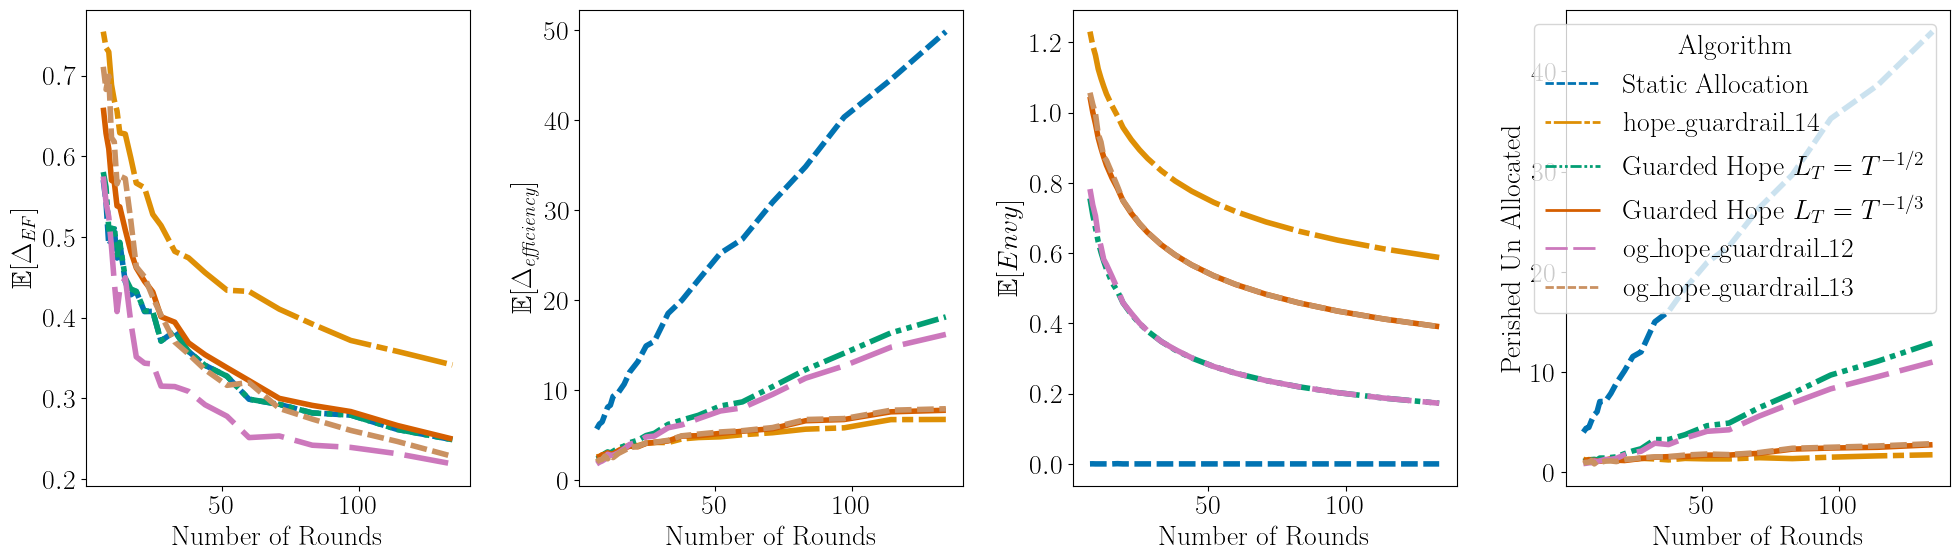

In [7]:
df.columns
df = df.assign(Algorithm = lambda df: df.Algorithm.replace(
    {'fixed_threshold': 'Static Allocation', 
     'hope_guardrail_13': 'Guarded Hope $L_T = T^{-1/3}$', 
     'hope_guardrail_12': 'Guarded Hope $L_T = T^{-1/2}$'}))


plt.style.use('PaperDoubleFig.mplstyle.txt')
plt.rc('text.latex', preamble=r'\usepackage{amsfonts}')

# Make some style choices for plotting 

dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]


filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

plt.rc('text', usetex=True)



fg, axs = plt.subplots(1,4, sharex='all', figsize=(20,6))
sns.lineplot(x='NumGroups', y='Value', hue=
             'Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'Counterfactual_Envy'], ax = axs[0], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)

sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Waste'], ax = axs[1], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)

sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Hindsight_Envy'], ax = axs[2], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)

sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Perished_Un_Allocated'], ax = axs[3], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)


axs[0].get_legend().remove()
axs[0].set_ylabel('$\mathbb{E}[\Delta_{\it EF}]$')
axs[0].set_xlabel('Number of Rounds')

axs[1].set_ylabel('$\mathbb{E}[\Delta_{\it efficiency}]$')
axs[1].set_xlabel('Number of Rounds')
axs[1].get_legend().remove()

axs[2].get_legend().remove()
axs[2].set_ylabel(r'$\mathbb{E}[Envy]$')
axs[2].set_xlabel('Number of Rounds')


# axs[3].get_legend().remove()
axs[3].set_ylabel(r'Perished Un Allocated')
axs[3].set_xlabel('Number of Rounds')

plt.show()
fg.savefig('./figures/'+file_name+'.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)